In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("/content/perez-fornos-2012_2xinterp.csv")
start_col_index = df.columns.get_loc("0.0")


# Use the column index to select the desired range of columns and convert to a NumPy array
data_np = df.iloc[:, start_col_index:].to_numpy()
#get rid of all the nan data
data_np = np.nan_to_num(data_np)

load data set from Perez Fornos et. al

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

max_range = len(data_np[44])
y_indices = {
    1: list(range(121)),  # This will create a list of integers from 0 to 61 inclusive
    2: list(range(121)),
    3: list(range(121)),
    4: list(range(41)),  # This will create a list of integers from 0 to 19 inclusive
    5: list(range(280)),  # Replace max_range with the actual upper limit for key 5
}
#i use the x_map to find the domain for each of the percepts for tests (conditions) 1-5
x_map = {
    1:np.linspace(0,30,121), #keys 1-5 correspond to condition
    2:np.linspace(0,30,121),
    3:np.linspace(0,30,121),
    4:np.linspace(0,10,41),
    5:np.linspace(0,70,280),
}

our first step is to find the optimal value to force the signal down to 0. i think the best way to do this is by searching the array to find an t_0 at which point all the y values to the right of it are < threshold.

In [ ]:
def find_t(y, threshold=1):
  for i in range(len(y)):
    found = False
    for j in range(i,len(y)):
      if y[j] > threshold:
        found = True
    if not found:
      return i
  return i

Processing the entire signal requires more terms. But we know that after t_0, our y values are basically 0. So instead of performing FFT analysis on the entire y, we process y[0:t_0]. This is better because it's really hard to model a signal that flatlines.

The code below takes the FFT of the signal and removes all coefficients less than the threshold. we will further process this fft and keep only n terms.

In [ ]:
def get_fft_res(y,t_0,spike=1):
  fft_res = np.fft.fft(y[spike:t_0+2])
  # Obtain the power spectrum (squared amplitude of each component)
  power_spectrum = np.abs(fft_res)**2
  # Zero out all small coefficients to remove noise
  threshold = 50
  fft_res[power_spectrum < threshold] = 0
  return fft_res

we pass the fft result to the function f which returns the filtered_fft and inverse fft that is an approximation of the signal built with only n terms

In [ ]:
from prompt_toolkit.formatted_text.utils import fragment_list_to_text

def f(fft_result,terms):
  if terms == 0: return np.zeros(len(fft_result)), np.zeros(len(fft_result))
  fft_result = fft_result
  magnitudes = np.abs(fft_result)
  top_indices = np.argsort(magnitudes)[-1*terms:] #sort the frequencies that correspond to the highest magnitudes

  filtered_fft = np.zeros_like(fft_result)
  filtered_fft[top_indices] = fft_result[top_indices] #filter to represent the signal using only the top "terms" frequencies

  reconstructed_signal = np.fft.ifft(filtered_fft)

  # If you need just the real part (assuming the imaginary part is numerical noise)
  reconstructed_signal = reconstructed_signal.real

  return filtered_fft, reconstructed_signal

In [ ]:
import numpy as np

# Assuming fft_result is the output from the FFT.
# Number of sample points
def get_rec_signal(y,fft_res,terms=0,spike=1):
  filtered_fft, ifft = f(fft_res,terms)
  rec_signal = np.concatenate((ifft,np.zeros(len(y) - len(ifft) - spike)))
  return rec_signal

interpolate for finer resolution

In [ ]:
def extend(x,y,rec_signal,spike=1):#this function linearly interpolates our data points out to a finer resolution
  new_indices_fft = np.linspace(0, len(y), (len(y) - spike)*10) #i want to save 10 pts for the spike
  new_indices_y = np.linspace(0, len(y), (len(y))*10)

  x_extend = np.interp(new_indices_y, np.arange(len(y)), x)
  y_extend = np.interp(new_indices_y, np.arange(len(y)), y)
  y_pred_extend = np.interp(new_indices_fft,np.arange(len(y) - spike),rec_signal)
  return x_extend, y_extend, y_pred_extend

In [ ]:
from scipy.signal import find_peaks
def decay_only(y_pred_extend):
  # Find the first local maximum in the data
  first_peak_index, _ = find_peaks(y_pred_extend, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
  if len(first_peak_index)==0:
    first_peak_index = np.append(first_peak_index,2)
  first_peak_y = y_pred_extend[first_peak_index[0]]

  # Make all values before the first local maxima NaN
  y_decayonly = np.copy(y_pred_extend)
  y_decayonly[:first_peak_index[0]] = np.nan
  return y_decayonly

In [ ]:
def add_spike(spike,y_decayonly,x_extend):
  #add the first spike which is just a linear interpolation
  y_spike = np.linspace(0, 10, spike*10)
  #y_model = np.copy(y_decayonly) #replace x_extend with x_t for cos/sin case
  y_model = np.concatenate((y_spike,y_decayonly))

  #remove nan
  non_nan_indices = ~np.isnan(y_model)
  x_non_nan = x_extend[non_nan_indices]
  y_non_nan = y_model[non_nan_indices]

  y_interpolated = np.interp(x_extend, x_non_nan, y_non_nan)
  return y_interpolated

In [ ]:
#how to force the end to zero??
def force_to_zero(t_0,y_interpolated):
  y_interpolated[t_0*10:] = 0
  return y_interpolated

Finally, apply a smoothing filter on the data... This makes some graphs look nicer (refines the piecewise connections), and others look worse :(

In [ ]:
from scipy.ndimage import gaussian_filter

def apply_gaussian_filter(data, spike, sigma,t_0): #note: we do not want to apply smoothing to the onset spike.
    smoothed_part = gaussian_filter(data[spike*10:], sigma=6)
    data[spike*10:] = smoothed_part
    data[0] = 0
    return data

RECAP of the procedure:

1) find the optimal t_0 value to cut the signal to 0

2) perform the fft analysis on the signal from y[1:t_0] (we ignore the spike and only model the decay)

3)concatenate the spike to the front of the model and flatline the model at t_0

4)apply a guassian filter

In [ ]:
from sklearn.metrics import r2_score, explained_variance_score

#these functions are used to calculate errors (mse, r2)
def calculate_r2(y_pred,y_actual,eps=1e-8,r2=True):
  if r2:
    value = r2_score(y_actual, y_pred)
  else:
    actual = (y_actual - y_actual.mean()) / (y_actual.std(ddof=0) + eps)
    pred = (y_pred - y_pred.mean()) / (y_pred.std(ddof=0) + eps)
    value = (actual * pred).mean()
  return value

def test(x,y,title="Reconstructed Signal",show=False, tau=None, terms=2, spike=2,pred_extended=None, bias=1):
  if tau: #tau is t0
    t_0 = int(tau * len(y))
  else:
    t_0 = find_t(y)
  fft_res = get_fft_res(y,t_0,spike=spike)
  rec_signal = get_rec_signal(y,fft_res,terms=terms,spike=spike)
  x_extend, y_extend, extended_rec_signal = extend(x,y,rec_signal,spike=spike)
  y_decayonly = decay_only(extended_rec_signal) + bias
  y_spike_and_decay = add_spike(spike,y_decayonly,x_extend)
  y_done = force_to_zero(t_0,y_spike_and_decay)
  y_smooth = apply_gaussian_filter(y_done,spike=spike,sigma=2,t_0=t_0)
  return y_smooth, y_extend, x_extend

def calculate_mse(y_smooth,y,weight=False): #note, you can create a weighted mse function if we care more about first n% of percept
  total = 0
  if len(y_smooth) == len(y):
    for i in range(len(y)):
      total += np.abs(y_smooth[i] - y[i])**2
    return total/len(y)


These functions are used later to compute the average values across patient groups and across condition groups. they are not used in the model.

In [ ]:
def group(mylist, ci=False):
  averages = [sum(mylist[i:i+9]) / 9 for i in range(0, len(mylist), 9)]
  stds = [1.96/3 * np.std(mylist[i:i+9]) for i in range(0, len(mylist), 9)]
  if not ci: return averages
  if ci: return averages, stds

def group_by_subject(mylist,subject, ci=False):
  total, count = 0,0
  sublist = []
  for i, val in enumerate(mylist):
      if i % 9 == subject:
        sublist.append(val)
        count += 1
        total += val
  if not ci: return total/count
  if ci: return [total/count, np.std(sublist) * 1.96/np.sqrt(count)]


we use test 1 as the baseline model (this is panels 1 to 9). test 1 was selected because it corresponds to the least extreme conditions.

In [ ]:
bl_start = 0
bl_end = 9
training_mse,validation_mse, training_r2, validation_r2, training_corr, validation_corr, validation_mse_cost, baseline_model = [],[],[],[],[],[],[],[]

find optimal takes the optimal parameters, the baseline model (from patients 1-9 on test 1, with the patient being tested in the validation set held out), and computes the training and validation errors

In [ ]:
def findoptimal(baseline,holdout_panel,tau,beta): #this function takes in a set of parameters and computes the training and validation errors

  x = x_map[holdout_panel//9+1]

  validation_panel = data_np[holdout_panel][0:len(x)]
  baseline_interp = np.interp(np.linspace(0, len(baseline)-1, len(x)), np.arange(len(baseline)), baseline)

  validation_interp = np.interp(np.linspace(0, len(validation_panel)-1, len(validation_panel)*10), np.arange(len(validation_panel)), validation_panel)
  #let's reconstruct the baseline model

  baseline_model, baseline_extend, x_extend = test(x,baseline_interp,bias=beta,tau=tau)

  baseline_model += 1e-10
  #can we find the best scale factor to fit the baseline to the training data
  start_index = (holdout_panel // 9) * 9
  end_index = start_index + 9
  training_mse, training_r2, training_corr = 0,0,0

  function = baseline_model
  function[0] = 0

  for j in list(range(start_index, holdout_panel)) + list(range(holdout_panel + 1, end_index)):
    train_panel = data_np[j][0:len(x)]
    training_interp = np.interp(np.linspace(0, len(train_panel)-1, len(train_panel)*10), np.arange(len(train_panel)), train_panel)
    training_mse += calculate_mse(function,training_interp)
    training_corr += calculate_r2(function,training_interp,r2=False)

  training_mse/= 8
  training_r2 /= 8
  training_corr /= 8

  validation_mse = calculate_mse(function,validation_interp,weight=False)
  validation_corr = calculate_r2(function,validation_interp,r2=False)


  return training_mse,validation_mse, training_corr, validation_corr, function


In [ ]:
import numpy as np
from scipy.optimize import minimize

def objective_function(params, start, end, data_np, x_map, tau):
    beta = params
    training_mse_lst, validation_mse_lst = [], []

    for i in range(start, end):
        indices = [j for j in range(0, 9) if j % 9 != i % 9]
        baseline = np.mean(np.concatenate([data_np[j:j+1] for j in indices]), axis=0)[0:len(x_map[1])]

        #note: tau corresponds to t_0, beta corresponds to bias
        training_mse, validation_mse, _, _, _ = findoptimal(baseline, i, tau=tau, beta=beta)
        training_mse_lst.append(training_mse)
        validation_mse_lst.append(validation_mse)

    return np.mean(training_mse_lst), np.mean(validation_mse_lst)

best_beta_map = {} #this saves the optimal beta values in a dictionary
sets = [(0, 9), (9, 18), (18, 27), (27, 36), (36, 45)] #these sets correspond to testing conditions
besttaus = {} #saves the best tau values (otpimal t_0)

for start, end in sets:
    best_validation_mse = float('inf')
    prev_result, best_tau = float('inf'), None
    for tau in np.linspace(0.2,0.5,20):
        initial_guess = [0] #this is to find the best beta value
        result = minimize(lambda params: objective_function(params, start, end, data_np, x_map, tau)[0], initial_guess, method='Nelder-Mead')
        current_training_mse, current_validation_mse = objective_function(result.x, start, end, data_np, x_map, tau)

        # Check if training MSE is improving, otherwise stop trianing, otherwise, store the reuslts and continue
        if current_training_mse <= prev_result:
            best_validation_mse = current_validation_mse
            prev_result = current_training_mse
            best_beta_map[start // 9 + 1] = result.x
            best_tau = tau
            besttaus[start//9 + 1] = tau
        else:
          break


    print("Set:", start // 9 + 1, "Optimal parameters:", result.x, "best tau: ", best_tau, "Validation MSE:", best_validation_mse)


Set: 1 Optimal parameters: [-0.3015] best tau:  0.3894736842105263 Validation MSE: 5.983212872157166
Set: 2 Optimal parameters: [-0.8185] best tau:  0.4052631578947369 Validation MSE: 6.255667572282157
Set: 3 Optimal parameters: [-1.495] best tau:  0.4210526315789474 Validation MSE: 7.056977598170974
Set: 4 Optimal parameters: [-0.3278125] best tau:  0.26315789473684215 Validation MSE: 7.240608637690915
Set: 5 Optimal parameters: [-2.060625] best tau:  0.4052631578947369 Validation MSE: 7.547693530857158


We use our optimal values to create the predicted panels, find the errors, and plot them against the real data.

<ipython-input-67-558fe4830fd7>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i)


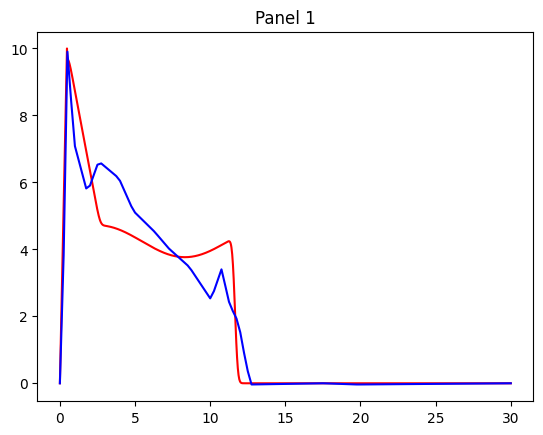

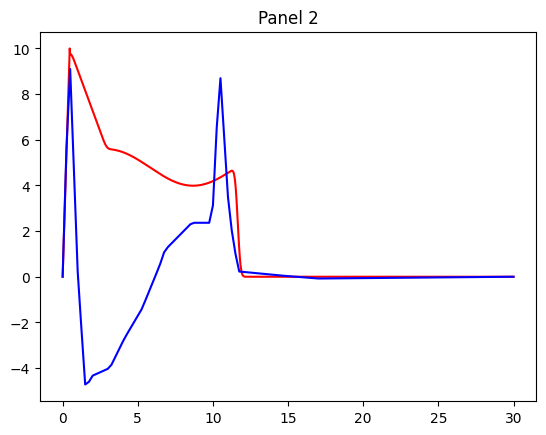

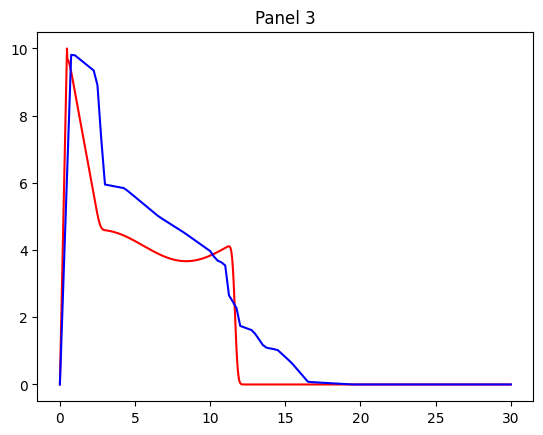

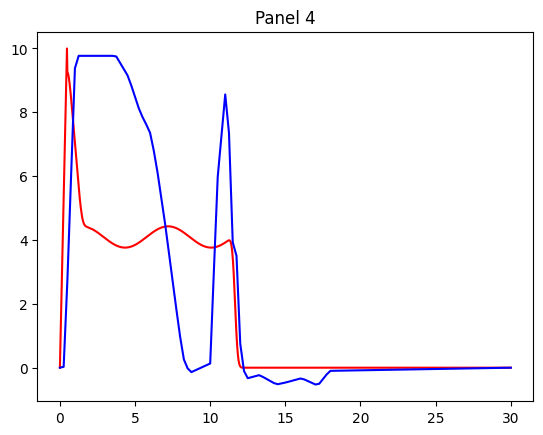

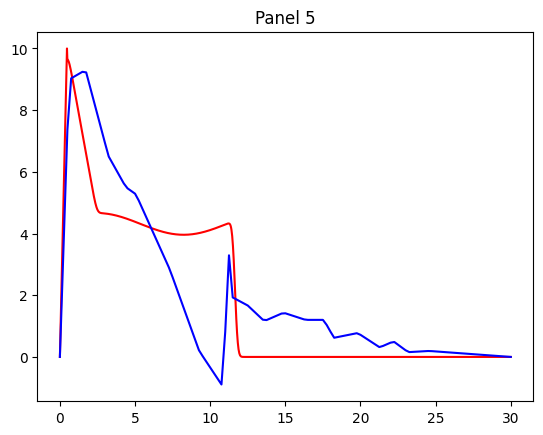

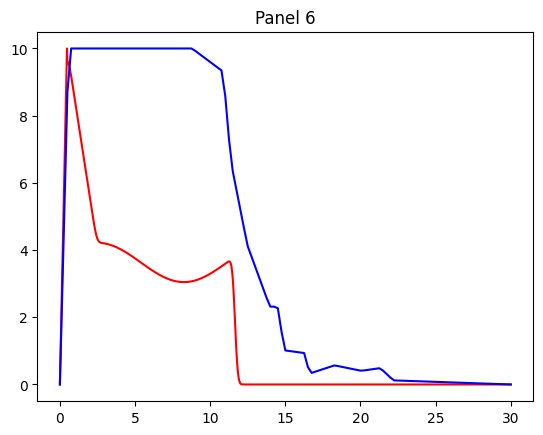

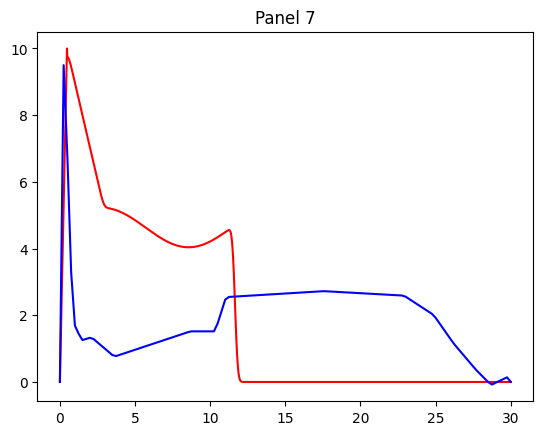

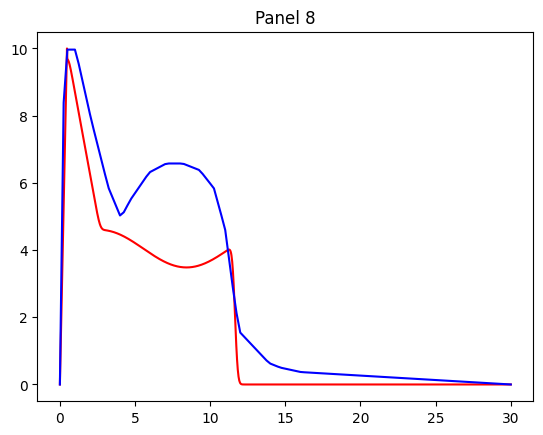

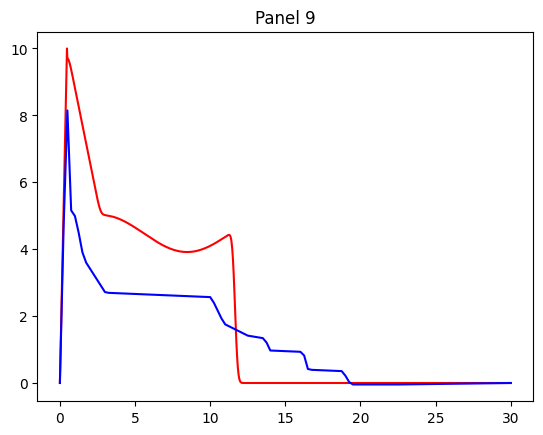

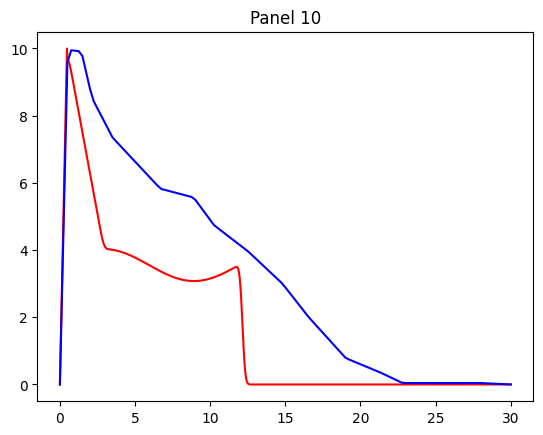

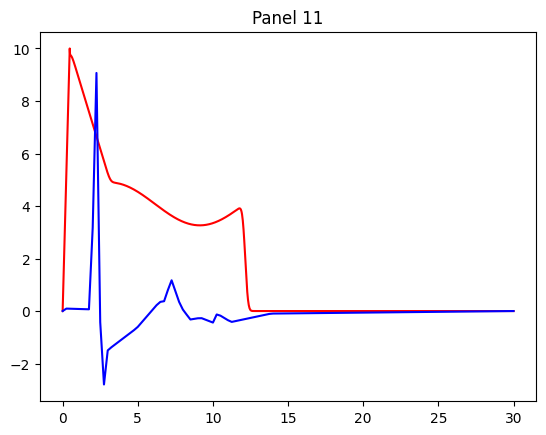

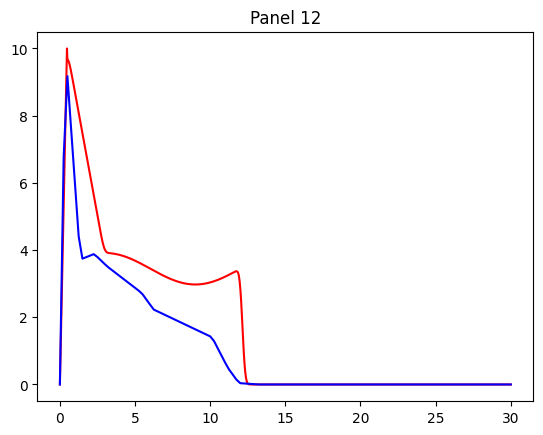

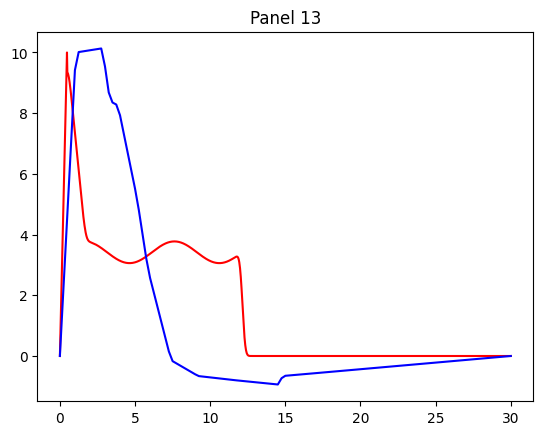

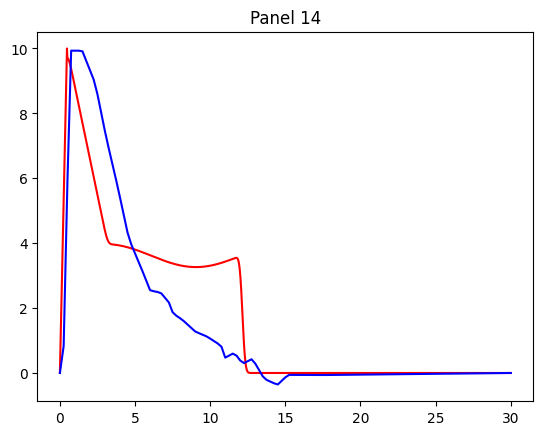

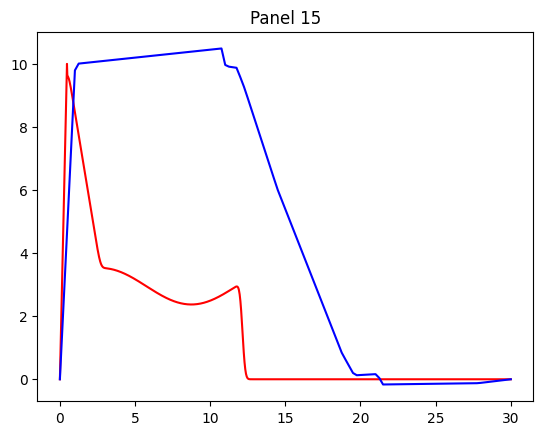

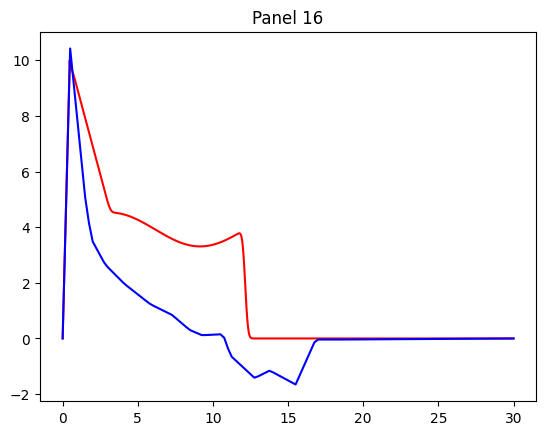

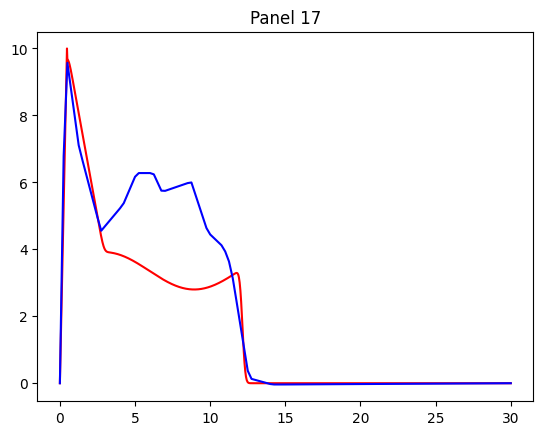

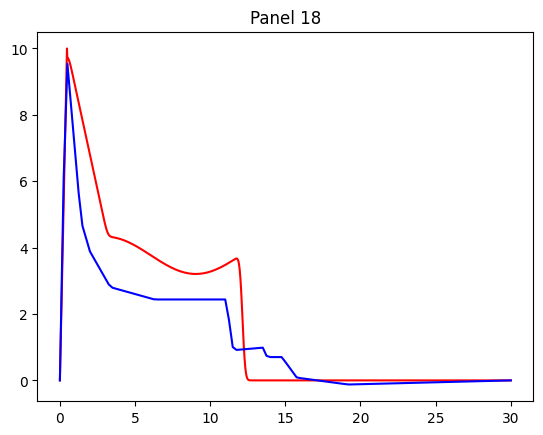

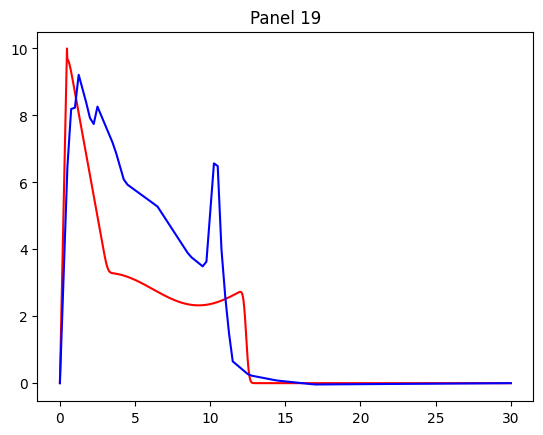

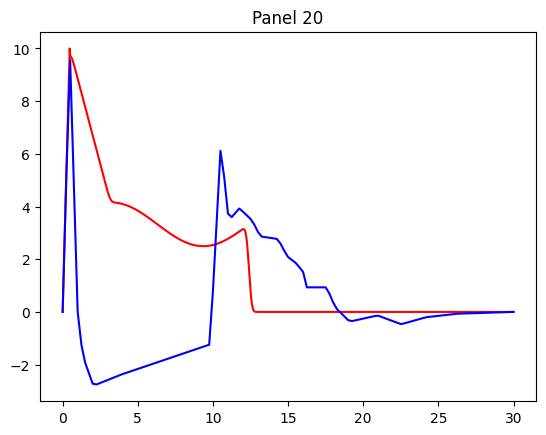

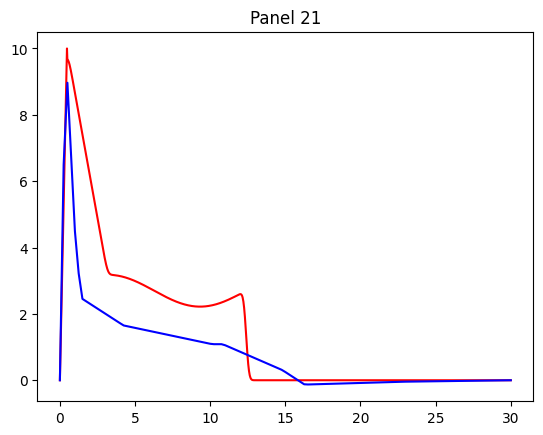

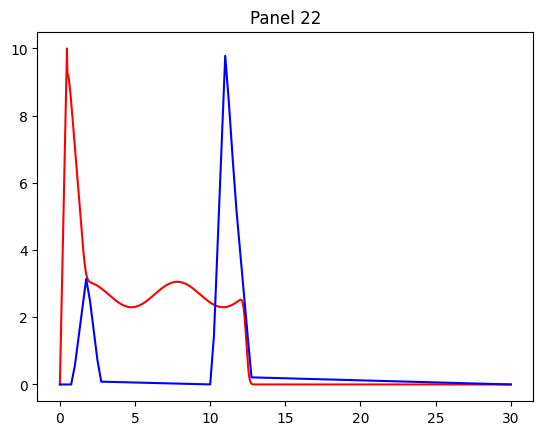

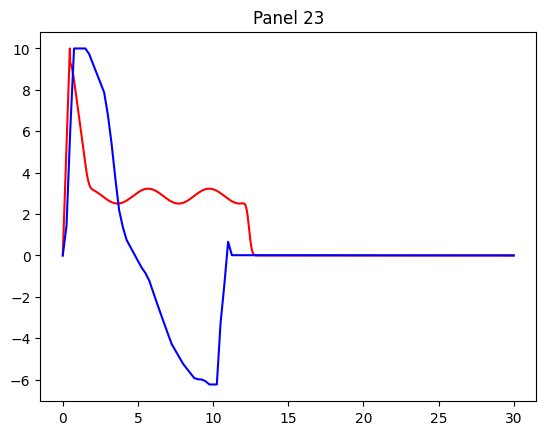

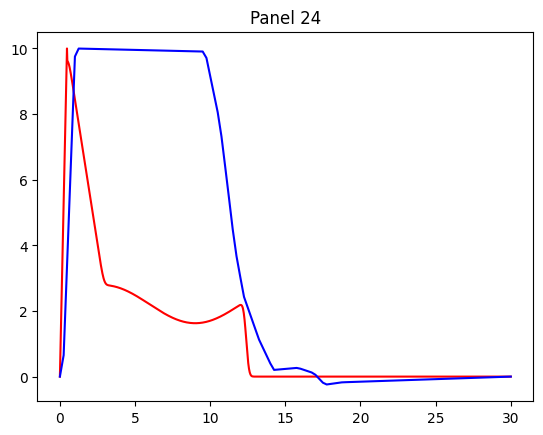

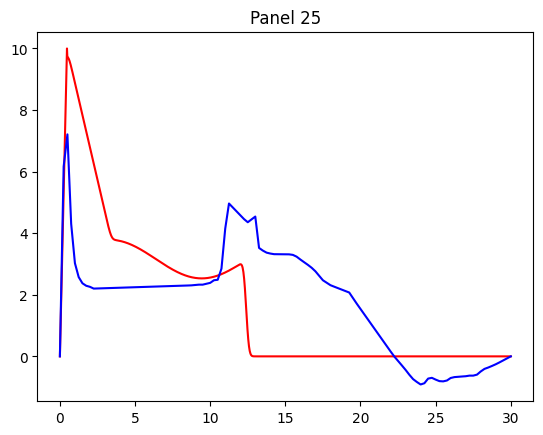

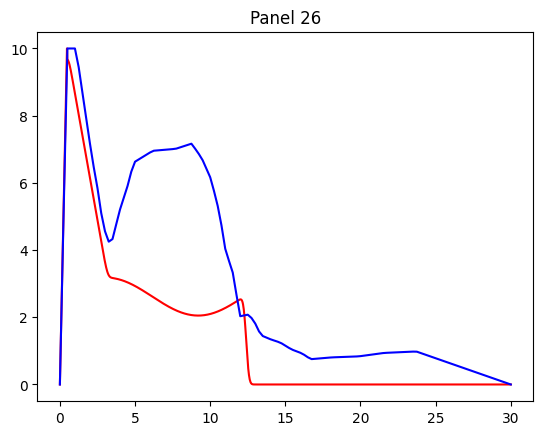

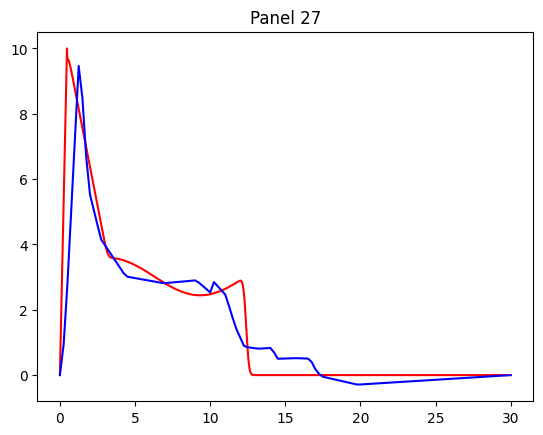

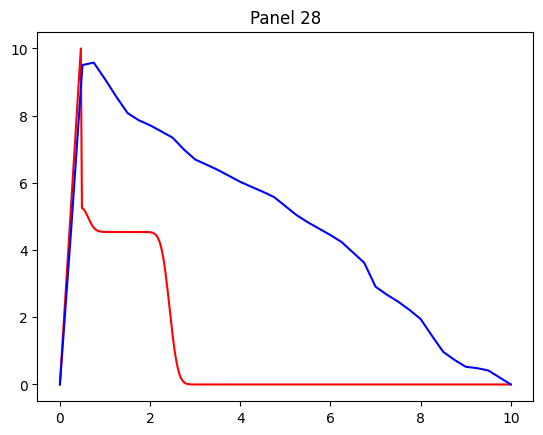

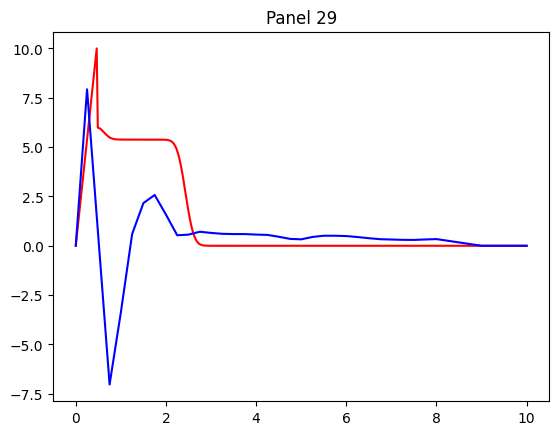

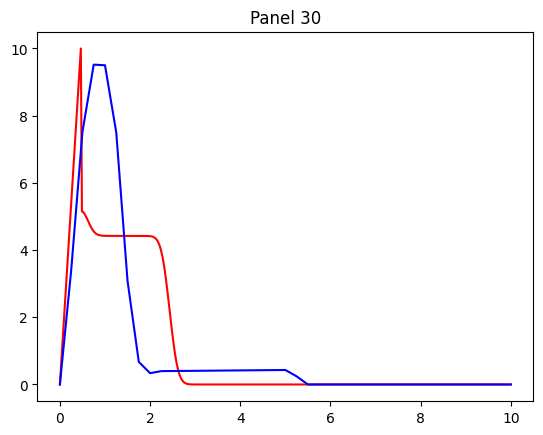

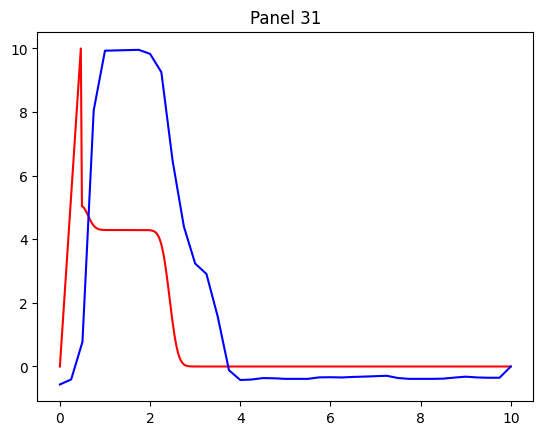

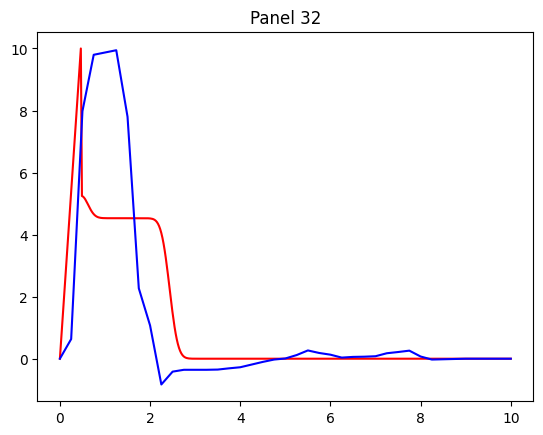

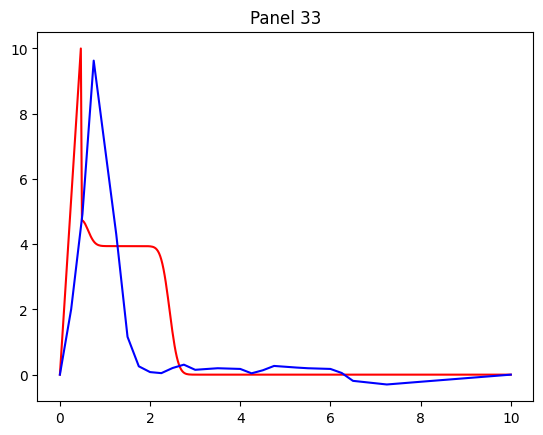

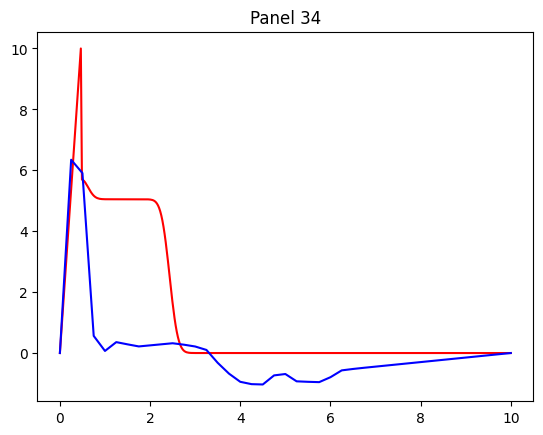

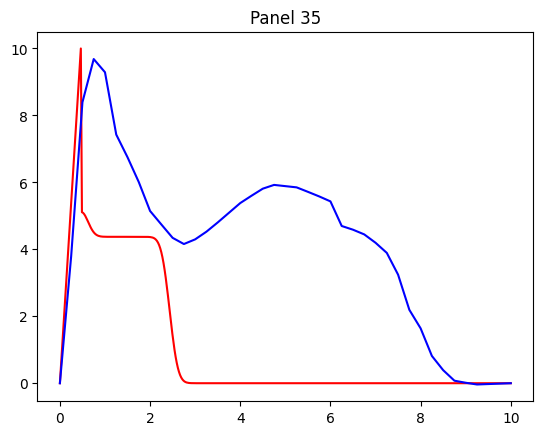

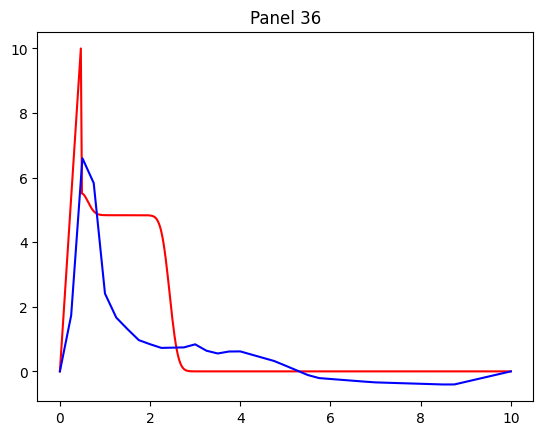

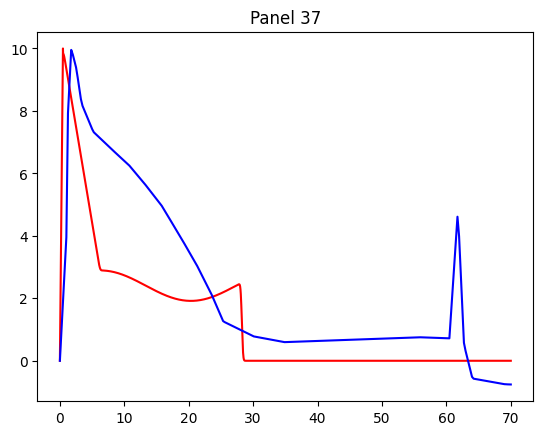

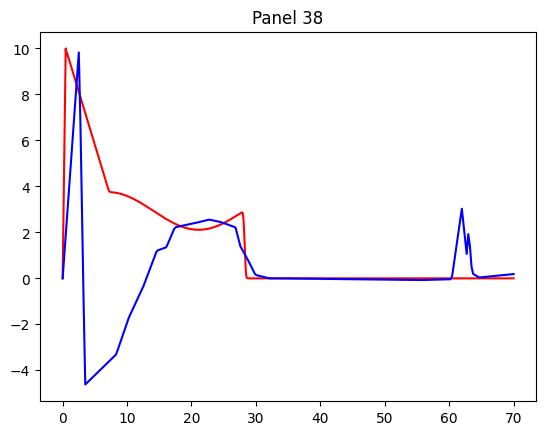

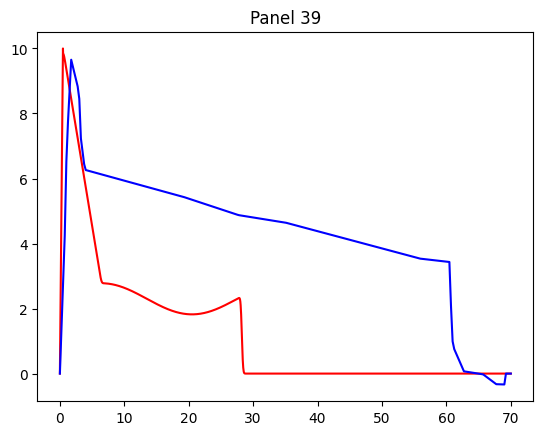

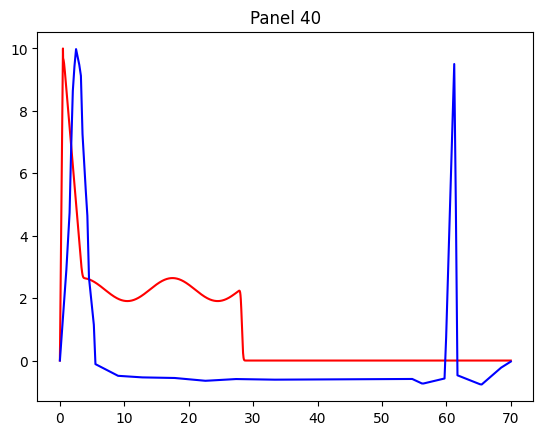

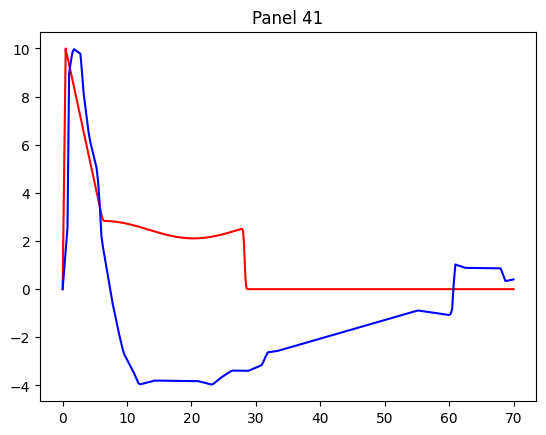

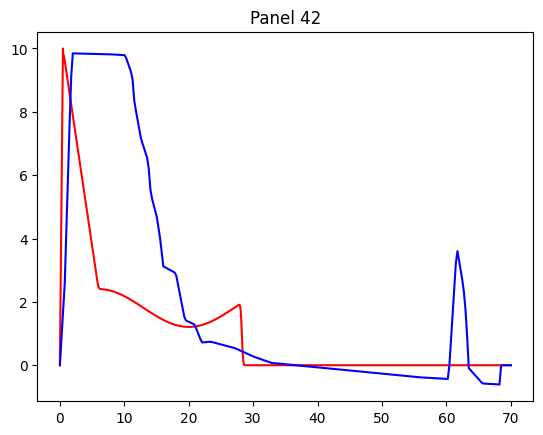

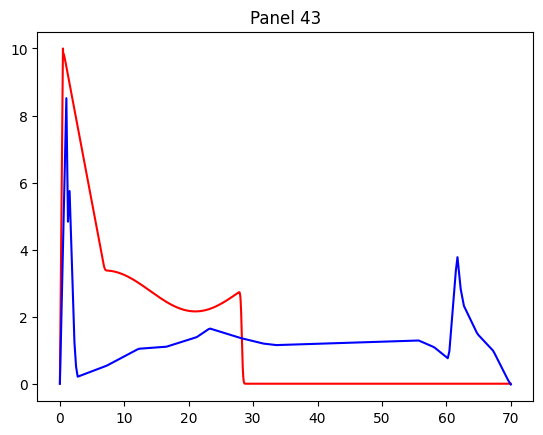

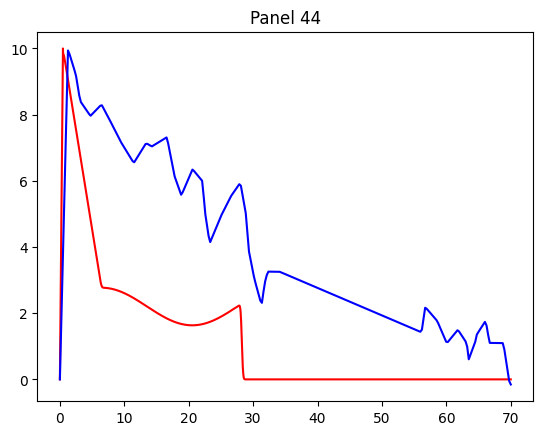

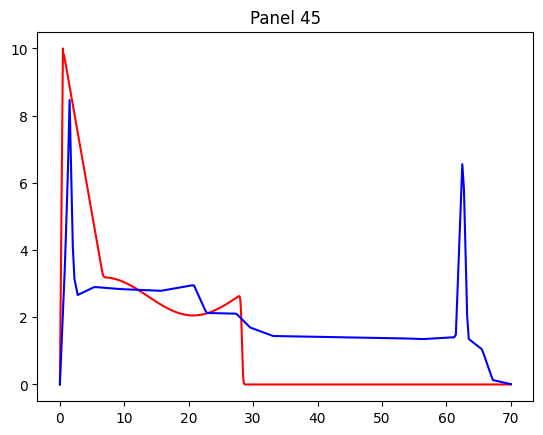

In [ ]:
plot = True
train_mse_lst, validation_mse_lst = [], []
train_r2_lst, val_r2_lst = [],[]
train_corr_lst, val_corr_lst = [],[] #creates empty lists iwth the error values


for i in range(45):
  indices = [j for j in range(0,9) if j % 9 != i % 9] #do not consider the ith patient in the dataset for cross validation
  baseline = np.mean(np.concatenate([data_np[j:j+1] for j in indices]), axis=0)[0:len(x_map[1])] #baseline calculated removing the ith patient
  beta = best_beta_map[i//9 + 1][0] #index the best_beta map from the training procedure
  tau = besttaus[i//9] #index the best tau map from the training procedure
  training_mse,validation_mse, training_corr, validation_corr, function = findoptimal(baseline,i,beta=beta,tau=tau) #pass the optimal values to make the prediction curve saved in the variable 'function'
  if plot:
    plt.figure(i)
    x = x_map[i//9 + 1]
    x_interp = np.interp(np.linspace(0, len(x)-1, len(x)*10), np.arange(len(x)), x)
    plt.plot(x_interp, function, 'r')
    plt.plot(x, data_np[i][0:len(x)], 'b')
    plt.title("Panel " + str(i + 1))

  #error results
  validation_mse_lst.append(validation_mse)
  train_mse_lst.append(training_mse)
  train_r2_lst.append(training_r2)
  val_r2_lst.append(validation_r2)
  train_corr_lst.append(training_corr)
  val_corr_lst.append(validation_corr)

In [ ]:
for i in range(9):
    mean, ci = group_by_subject(validation_mse_lst, i, ci=True)
    print(f"subject: {i+1}, validation mse score: {mean:.3f} ± {ci:.3f}")


print("-------------------------------------------")

for i in range(9):
    mean, ci = group_by_subject(val_corr_lst, i, ci=True)
    print(f"subject: {i+1}, validation correlation score: {mean:.3f} ± {ci:.3f}")

total_validation_mse = sum(validation_mse_lst)
print("Total validation MSE:", total_validation_mse)


subject: 1, validation mse score: 5.617 ± 5.324
subject: 2, validation mse score: 11.491 ± 2.375
subject: 3, validation mse score: 3.766 ± 3.659
subject: 4, validation mse score: 6.376 ± 1.138
subject: 5, validation mse score: 6.851 ± 4.338
subject: 6, validation mse score: 13.584 ± 6.853
subject: 7, validation mse score: 5.204 ± 1.674
subject: 8, validation mse score: 6.595 ± 4.509
subject: 9, validation mse score: 1.868 ± 0.658
-------------------------------------------
subject: 1, validation correlation score: 0.838 ± 0.104
subject: 2, validation correlation score: 0.036 ± 0.073
subject: 3, validation correlation score: 0.831 ± 0.118
subject: 4, validation correlation score: 0.546 ± 0.169
subject: 5, validation correlation score: 0.641 ± 0.190
subject: 6, validation correlation score: 0.709 ± 0.066
subject: 7, validation correlation score: 0.435 ± 0.278
subject: 8, validation correlation score: 0.814 ± 0.139
subject: 9, validation correlation score: 0.853 ± 0.093
Total validation M

In [ ]:
# @title
best_alpha_map

In [ ]:


averages_val_mse, stds_val_mse = group(validation_mse_lst, ci=True)
for i in range(len(averages_val_mse)):
    print(f"figure: {i+3}, validation mse score: {averages_val_mse[i]:.3f} ± {stds_val_mse[i]:.3f}")

print("----------------------------------------------")

averages_val_corr, stds_val_corr = group(val_corr_lst, ci=True)
for i in range(len(averages_val_corr)):
    print(f"figure: {i+3}, validation corr score: {averages_val_corr[i]:.3f} ± {stds_val_corr[i]:.3f}")

total_validation_mse = sum(validation_mse_lst)
print("Total validation MSE:", f"{total_validation_mse:.4f}")


figure: 3, validation mse score: 5.983 ± 3.572
figure: 4, validation mse score: 6.256 ± 4.807
figure: 5, validation mse score: 7.057 ± 3.725
figure: 6, validation mse score: 7.241 ± 3.459
figure: 7, validation mse score: 7.548 ± 2.281
----------------------------------------------
figure: 3, validation corr score: 0.683 ± 0.256
figure: 4, validation corr score: 0.760 ± 0.168
figure: 5, validation corr score: 0.567 ± 0.229
figure: 6, validation corr score: 0.612 ± 0.138
figure: 7, validation corr score: 0.547 ± 0.143
Total validation MSE: 306.7574


0 Terms: [6.675344388532222, 10.613966756864157]\
1 Terms: [5.298243699235417, 8.184736679250896]\
2 Terms: [4.381185311924707, 7.276966625873781]\
3 Terms: [4.312925785533119, 7.266062385906608]\
4 Terms: [4.304288310589712, 7.252889801749241]\
5 Terms: [4.305840873459386, 7.252501332105514]\
6 Terms: [4.300362734871593, 7.242520912141618]\


In [ ]:
print(np.mean(validation_mse_lst))
print(np.std(validation_mse_lst))
print(np.mean(val_corr_lst))
print(np.std(val_corr_lst))

6.816832042231673
5.631004078707387
0.6337799361198753
0.3049079021276881
